In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchsampler

In [3]:
# train_b7_multitask_full.py  (with confusion matrices at the end)
import os, random, pandas as pd, torch, torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsampler import ImbalancedDatasetSampler  # pip install torchsampler

In [4]:
# ======== Config ========
CSV_PATH   = "/content/drive/MyDrive/data/streetSurfaceVis_v1_0_2.csv"
IMG_DIR    = "/content/drive/MyDrive/data/s_1024"
BATCH_SIZE = 8
EPOCHS     = 40
LR         = 3e-4
PATIENCE   = 10
NUM_MATERIALS, NUM_QUALITIES = 5, 5
SEED = 42

In [5]:
# ======== Column names ========

import pandas as pd

# Load the CSV file to inspect column names
df_inspect = pd.read_csv(CSV_PATH)
print(df_inspect.columns)

Index(['mapillary_image_id', 'path', 'filepath', 'user_id', 'user_name',
       'captured_at', 'longitude', 'latitude', 'train', 'type',
       'surface_quality'],
      dtype='object')


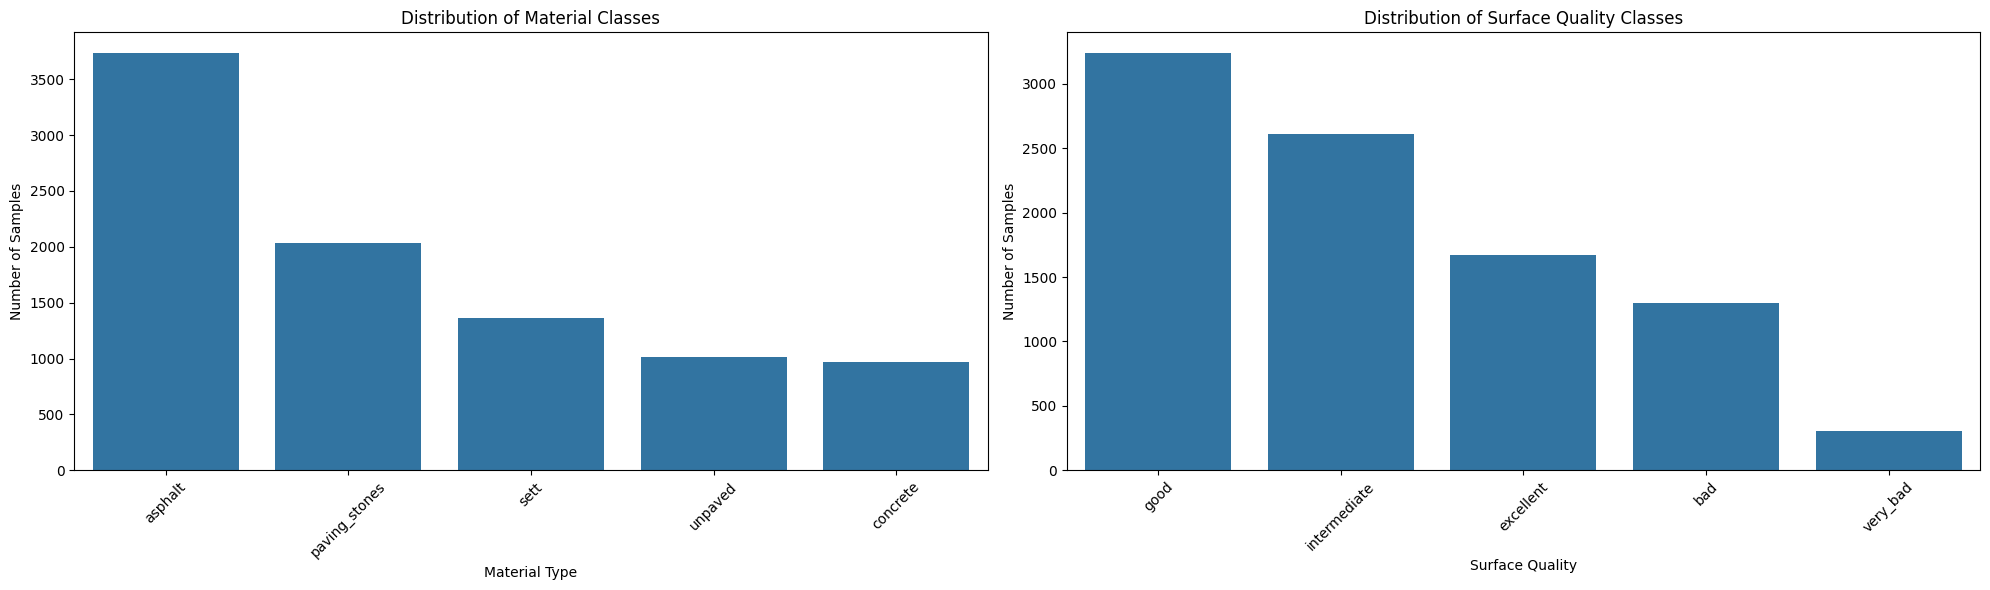

In [6]:
# ======== Data exploration analyis ========

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CSV file
df = pd.read_csv(CSV_PATH)

# Count occurrences for 'type' (material)
material_counts = df['type'].value_counts()

# Count occurrences for 'surface_quality'
quality_counts = df['surface_quality'].value_counts()

# Create subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# Create bar plot for material classes on the first subplot
sns.barplot(x=material_counts.index, y=material_counts.values, ax=axes[0])
axes[0].set_title('Distribution of Material Classes')
axes[0].set_xlabel('Material Type')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45) # Removed ha='right'

# Create bar plot for quality classes on the second subplot
sns.barplot(x=quality_counts.index, y=quality_counts.values, ax=axes[1])
axes[1].set_title('Distribution of Surface Quality Classes')
axes[1].set_xlabel('Surface Quality')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45) # Removed ha='right'

plt.tight_layout()
plt.show()

In [7]:
# ======== Repro ========
random.seed(SEED); torch.manual_seed(SEED)

# ======== Label maps ========
master_class = {"asphalt":0,"concrete":1,"paving_stones":2,"unpaved":3,"sett":4}
sub_class    = {"excellent":0,"good":1,"intermediate":2,"bad":3,"very_bad":4}
material_names = [k for k,_ in sorted(master_class.items(), key=lambda x:x[1])]
quality_names  = [k for k,_ in sorted(sub_class.items(),   key=lambda x:x[1])]

# ======== Device & speed ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True

In [8]:
# ======== Transforms ========
tfms = transforms.Compose([
    transforms.Resize((600, 600)), # Resize to 600x600 because EfficientNet b7
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [9]:
# ======== Dataset ========
class StreetDS(Dataset):
    def __init__(self, csv_path, img_dir, tfm=tfms):
        df = pd.read_csv(csv_path)
        self.paths = [os.path.join(img_dir, f) for f in df["filepath"]]
        self.mat   = [master_class[m] for m in df["type"]]
        self.qual  = [sub_class[q]    for q in df["surface_quality"]]
        self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        x = self.tfm(Image.open(self.paths[i]).convert("RGB"))
        return x, (torch.tensor(self.mat[i]), torch.tensor(self.qual[i]))

In [15]:
# ======== Split & Loaders (imbalanced sampler on train) ========
ds = StreetDS(CSV_PATH, IMG_DIR)
idx = torch.randperm(len(ds)); n_tr = int(0.8*len(ds))
tr_ds, va_ds = Subset(ds, idx[:n_tr]), Subset(ds, idx[n_tr:])

train_sampler = ImbalancedDatasetSampler(
    tr_ds, callback_get_label=lambda subset: [ds.mat[i] for i in subset.indices]
)
# For joint balance (material, quality), use:
# train_sampler = ImbalancedDatasetSampler(
#     tr_ds, callback_get_label=lambda subset: [(ds.mat[i], ds.qual[i]) for i in subset.indices]
# )


train_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=train_sampler,
                      num_workers=0, pin_memory=True, persistent_workers=False)
val_dl   = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=True, persistent_workers=False)

In [11]:
# ======== Model ========
class MultiHeadEffNetB7(nn.Module):
    def __init__(self):
        super().__init__()
        base = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])
        f = base.classifier[1].in_features  # 2560
        self.mat, self.qual = nn.Linear(f, NUM_MATERIALS), nn.Linear(f, NUM_QUALITIES)
    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.mat(x), self.qual(x)

model = MultiHeadEffNetB7().to(device)
try: model = torch.compile(model)
except: pass

opt = torch.optim.AdamW(model.parameters(), lr=LR)
lossfn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)

# AMP
try:
    # Try importing from the newer torch.amp first as recommended by the warning
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
except ImportError:
    # Fallback to the older torch.cuda.amp if torch.amp is not available
    try:
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler()
    except Exception as e:
         # Fallback if neither works, maybe for CPU or very old versions
         print(f"AMP not fully available: {e}, proceeding without it.")
         # Define dummy autocast and GradScaler if AMP is not available
         class autocast:
             def __enter__(self): pass
             def __exit__(self, exc_type, exc_val, exc_tb): pass
         class GradScaler:
             def scale(self, loss): return loss
             def step(self, optimizer): optimizer.step()
             def update(self): pass
         scaler = GradScaler()

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth


100%|██████████| 255M/255M [00:01<00:00, 225MB/s]


In [12]:
# ======== Train / Validate / Early Stop ========
best_metric, wait = -1.0, 0
epoch_metrics = [] # List to store metrics per epoch

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train(); train_loss = 0.0
    for imgs, (mat_y, qual_y) in train_dl:
        imgs = imgs.to(device, non_blocking=True)
        mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
        with autocast(device_type=device.type): # Pass device type to autocast
            m_logits, q_logits = model(imgs)
            loss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        train_loss += loss.item()

    # ---- Validate ----
    model.eval(); val_loss = 0.0; mat_ok = qual_ok = n = 0
    with torch.no_grad():
        for imgs, (mat_y, qual_y) in val_dl:
            imgs = imgs.to(device, non_blocking=True)
            mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
            with autocast(device_type=device.type): # Pass device type to autocast
                m_logits, q_logits = model(imgs)
                vloss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
            val_loss += vloss.item()
            mat_ok += (m_logits.argmax(1) == mat_y).sum().item()
            qual_ok += (q_logits.argmax(1) == qual_y).sum().item()
            n += mat_y.size(0)

    mat_acc, qual_acc = (mat_ok/n if n else 0.0), (qual_ok/n if n else 0.0)
    metric = 0.5 * (mat_acc + qual_acc)
    epoch_metrics.append(metric) # Store the metric

    scheduler.step(metric)

    # ---- Save checkpoints & early stop ----
    torch.save(model.state_dict(), f"ckpt_epoch{epoch}.pt")
    if metric > best_metric:
        best_metric, wait = metric, 0
        torch.save(model.state_dict(), "best_model.pt")
        flag = " ✅ best updated"
    else:
        wait += 1; flag = ""

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.3f}  val_loss={val_loss:.3f}  "
          f"mat_acc={mat_acc:.3f}  qual_acc={qual_acc:.3f}  avg_acc={metric:.3f}  "
          f"lr={opt.param_groups[0]['lr']:.2e}{flag}")

    if wait >= PATIENCE:
        print(f"⏹️  Early stopping: no accuracy improvement for {PATIENCE} epochs.")
        break

Epoch 01/40 | train_loss=1255.821  val_loss=285.948  mat_acc=0.888  qual_acc=0.585  avg_acc=0.736  lr=3.00e-04 ✅ best updated
Epoch 02/40 | train_loss=852.822  val_loss=268.425  mat_acc=0.899  qual_acc=0.597  avg_acc=0.748  lr=3.00e-04 ✅ best updated
Epoch 03/40 | train_loss=641.678  val_loss=263.388  mat_acc=0.907  qual_acc=0.654  avg_acc=0.781  lr=3.00e-04 ✅ best updated
Epoch 04/40 | train_loss=527.132  val_loss=306.901  mat_acc=0.908  qual_acc=0.604  avg_acc=0.756  lr=3.00e-04


KeyboardInterrupt: 

In [16]:
# Find the last saved checkpoint
checkpoint_files = [f for f in os.listdir('.') if f.startswith('ckpt_epoch') and f.endswith('.pt')]
if not checkpoint_files:
    print("No checkpoints found to resume training.")
else:
    # Sort by epoch number to get the latest
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('ckpt_epoch')[1].split('.pt')[0]))[-1]
    print(f"Resuming from checkpoint: {latest_checkpoint}")

    # Load the model state
    model.load_state_dict(torch.load(latest_checkpoint))

    # Determine the starting epoch
    start_epoch = int(latest_checkpoint.split('ckpt_epoch')[1].split('.pt')[0]) + 1

    # Resume training loop
    best_metric, wait = -1.0, 0 # Reset or load from a saved state if you were saving these
    # If you saved best_metric and wait along with the checkpoint, load them here.
    # For simplicity, we'll reset them here.

    for epoch in range(start_epoch, EPOCHS + 1):
        # ---- Train ----
        model.train(); train_loss = 0.0
        for imgs, (mat_y, qual_y) in train_dl:
            imgs = imgs.to(device, non_blocking=True)
            mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
            with autocast(device_type=device.type): # Pass device type to autocast
                m_logits, q_logits = model(imgs)
                loss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            train_loss += loss.item()

        # ---- Validate ----
        model.eval(); val_loss = 0.0; mat_ok = qual_ok = n = 0
        with torch.no_grad():
            for imgs, (mat_y, qual_y) in val_dl:
                imgs = imgs.to(device, non_blocking=True)
                mat_y, qual_y = mat_y.to(device, non_blocking=True), qual_y.to(device, non_blocking=True)
                with autocast(device_type=device.type): # Pass device type to autocast
                    m_logits, q_logits = model(imgs)
                    vloss = lossfn(m_logits, mat_y) + lossfn(q_logits, qual_y)
                val_loss += vloss.item()
                mat_ok += (m_logits.argmax(1) == mat_y).sum().item()
                qual_ok += (q_logits.argmax(1) == qual_y).sum().item()
                n += mat_y.size(0)

        mat_acc, qual_acc = (mat_ok/n if n else 0.0), (qual_ok/n if n else 0.0)
        metric = 0.5 * (mat_acc + qual_acc)
        # epoch_metrics.append(metric) # Uncomment if you want to continue tracking metrics

        scheduler.step(metric)

        # ---- Save checkpoints & early stop ----
        torch.save(model.state_dict(), f"ckpt_epoch{epoch}.pt")
        if metric > best_metric:
            best_metric, wait = metric, 0
            torch.save(model.state_dict(), "best_model.pt")
            flag = " ✅ best updated"
        else:
            wait += 1; flag = ""

        print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.3f}  val_loss={val_loss:.3f}  "
              f"mat_acc={mat_acc:.3f}  qual_acc={qual_acc:.3f}  avg_acc={metric:.3f}  "
              f"lr={opt.param_groups[0]['lr']:.2e}{flag}")

        if wait >= PATIENCE:
            print(f"⏹️  Early stopping: no accuracy improvement for {PATIENCE} epochs.")
            break

Resuming from checkpoint: ckpt_epoch4.pt
Epoch 05/40 | train_loss=521.306  val_loss=185.850  mat_acc=0.961  qual_acc=0.738  avg_acc=0.850  lr=3.00e-04 ✅ best updated
Epoch 06/40 | train_loss=392.478  val_loss=283.057  mat_acc=0.953  qual_acc=0.641  avg_acc=0.797  lr=3.00e-04
Epoch 07/40 | train_loss=304.497  val_loss=237.352  mat_acc=0.941  qual_acc=0.732  avg_acc=0.837  lr=3.00e-04
Epoch 08/40 | train_loss=294.793  val_loss=209.976  mat_acc=0.952  qual_acc=0.738  avg_acc=0.845  lr=1.50e-04
Epoch 09/40 | train_loss=155.043  val_loss=190.499  mat_acc=0.969  qual_acc=0.750  avg_acc=0.859  lr=1.50e-04 ✅ best updated
Epoch 10/40 | train_loss=100.715  val_loss=205.412  mat_acc=0.953  qual_acc=0.755  avg_acc=0.854  lr=1.50e-04
Epoch 11/40 | train_loss=83.286  val_loss=235.388  mat_acc=0.966  qual_acc=0.755  avg_acc=0.860  lr=1.50e-04 ✅ best updated
Epoch 12/40 | train_loss=72.564  val_loss=251.358  mat_acc=0.959  qual_acc=0.738  avg_acc=0.848  lr=1.50e-04
Epoch 13/40 | train_loss=64.754  val

In [17]:
import os
import shutil

# Define the source file path (the model checkpoint in the current directory)
source_file = "best_model.pt"

# Define the destination directory in your Google Drive
# Make sure this directory exists in your Drive, or create it if necessary
destination_dir = "/content/drive/MyDrive/saved_models/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Define the full destination path for the file
destination_file = os.path.join(destination_dir, os.path.basename(source_file))

# Copy the file from the source to the destination
try:
    shutil.copy(source_file, destination_file)
    print(f"Successfully copied {source_file} to {destination_file}")
except FileNotFoundError:
    print(f"Error: Source file '{source_file}' not found.")
except Exception as e:
    print(f"An error occurred while copying the file: {e}")

Successfully copied best_model.pt to /content/drive/MyDrive/saved_models/best_model.pt


In [ ]:
# ======== Final Evaluation: Confusion Matrices (val set) ========
cm_mat  = torch.zeros(NUM_MATERIALS, NUM_MATERIALS, dtype=torch.int64)  # [true, pred]
cm_qual = torch.zeros(NUM_QUALITIES, NUM_QUALITIES, dtype=torch.int64)

model.eval()
with torch.no_grad():
    for imgs, (mat_y, qual_y) in val_dl:
        imgs = imgs.to(device, non_blocking=True)
        mat_y, qual_y = mat_y.to(device), qual_y.to(device)
        m_logits, q_logits = model(imgs)
        m_pred, q_pred = m_logits.argmax(1), q_logits.argmax(1)
        for t, p in zip(mat_y.view(-1), m_pred.view(-1)):
            cm_mat[t.long(), p.long()] += 1
        for t, p in zip(qual_y.view(-1), q_pred.view(-1)):
            cm_qual[t.long(), p.long()] += 1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns

# Plot Material Confusion Matrix
sns.heatmap(cm_mat.cpu().numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=material_names, yticklabels=material_names, ax=axes[0])
axes[0].set_title('Confusion Matrix: Material')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot Quality Confusion Matrix
sns.heatmap(cm_qual.cpu().numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=quality_names, yticklabels=quality_names, ax=axes[1])
axes[1].set_title('Confusion Matrix: Quality')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming epoch_metrics list is available from the training loop execution (cell 2_DfbKh5bcct)

epochs = range(1, len(epoch_metrics) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_metrics, marker='o', linestyle='-')
plt.title('Average Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(epochs) # Ensure all epochs are shown on the x-axis
plt.show()

In [13]:
import os
import datetime

file_path = "/content/best_model.pt"
try:
    # Get the creation time (ctime) of the file
    ctime_timestamp = os.path.getctime(file_path)
    ctime_datetime = datetime.datetime.fromtimestamp(ctime_timestamp)
    print(f"The file '{file_path}' was created on: {ctime_datetime}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

The file '/content/best_model.pt' was created on: 2025-08-29 01:12:48.480273
